# # Its the same source code as covid_charts.ph

 Le nom du département est :Alpes-Maritimes , et la population en 2020 est estimée à :1 079 396 / ratio appliqué=0.9264440483381446
 Le nom du département est :Bouches-du-Rhone , et la population en 2020 est estimée à :2 034 469 / ratio appliqué=0.491528747796108
 Le nom du département est :Isere , et la population en 2020 est estimée à :1 264 979 / ratio appliqué=0.7905269573645096
 Le nom du département est :Loire , et la population en 2020 est estimée à :764 737 / ratio appliqué=1.3076390968398286
 Le nom du département est :Rhone , et la population en 2020 est estimée à :1 876 051 / ratio appliqué=0.533034549700408
 Le nom du département est :Paris , et la population en 2020 est estimée à :2 148 271 / ratio appliqué=0.465490620131259
 Le nom du département est :Var , et la population en 2020 est estimée à :1 073 836 / ratio appliqué=0.9312408971202306
          jour          06          13          38          42          69  \
191 2020-11-20  219.170192  265.776616  446.308934  43

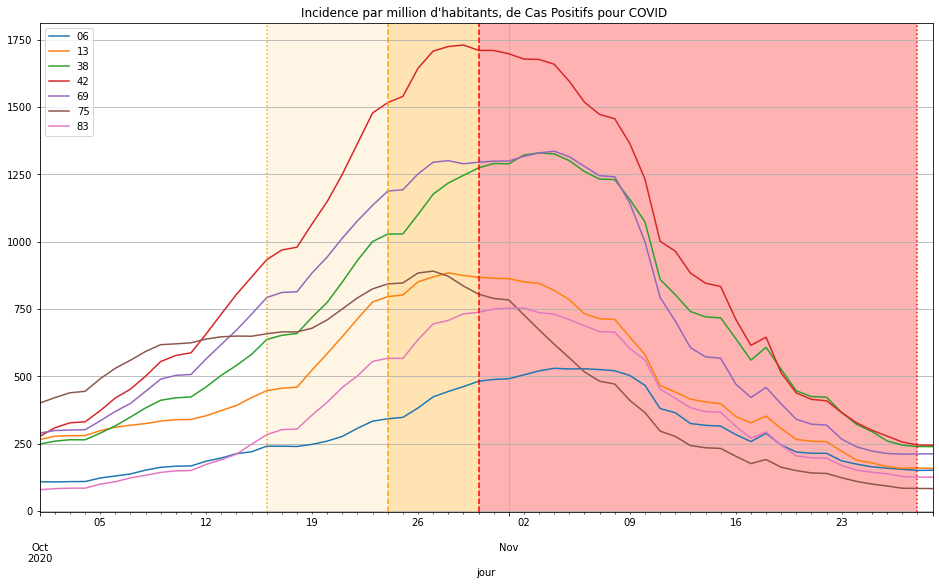

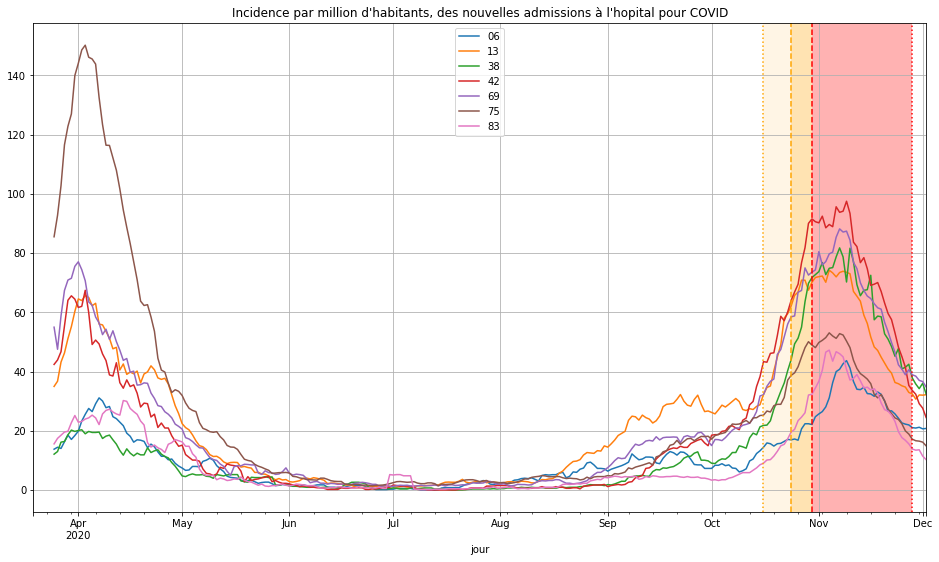

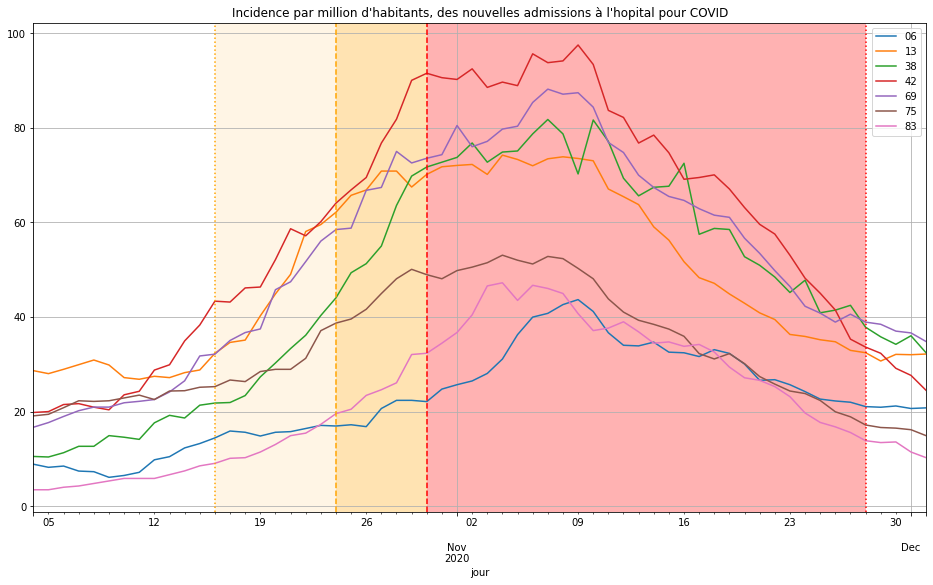

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Population data from : https://www.insee.fr/fr/statistiques/1893198
popEx = pd.read_csv("data/population_2020.csv",sep=";")
popEx


#datetime  convert based on https://gist.github.com/gjreda/7433f5f70299610d9b6b
from datetime import datetime
#convert from 2020-03-19
to_datetime = lambda d: datetime.strptime(d, '%Y-%m-%d')
#convert from 19/03/2020
to_frDate = lambda dt: datetime.strptime(dt,'%d/%m/%Y')

#Curfew and confinement dates from https://fr.wikipedia.org/wiki/Couvre-feu_de_2020_en_France

firstCurfew_date=to_datetime("2020-10-16")
secondCurfew_date=to_datetime("2020-10-24")
second_confinement_date = to_datetime("2020-10-30")
lite_confinement_date = to_datetime("2020-11-28")

def draw_curfew_dates():
    plt.axvspan(firstCurfew_date, secondCurfew_date, facecolor='orange', alpha=0.1)
    plt.axvspan( secondCurfew_date,second_confinement_date, facecolor='orange', alpha=0.3)
    plt.axvspan(second_confinement_date,lite_confinement_date, facecolor='red', alpha=0.3)
    plt.axvline(x=firstCurfew_date, label="Permier couvre-feu 10 métroples", color='orange',linestyle=':')
    plt.axvline(x=secondCurfew_date, label="Deuxième couvre-feu 54 départements", color='orange',linestyle='--')
    plt.axvline(x=second_confinement_date, label="Confinement", color='red',linestyle='--')
    plt.axvline(x=lite_confinement_date, label="Confinement", color='red',linestyle=':')

#données des test PCR issue de santé public
#PCR data from : https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/
raw_tests = pd.read_csv("data/sp-pos-quot-dep-2020-12-02-19h15.csv",sep=";",dtype={"dep":str,"P":int,"T":int}, converters={'jour': to_datetime})
raw_tests["Cas Positifs"] = np.nan
raw_tests["ppm"] = np.nan #ppm= Positif cases per million
raw_tests["positivity"]= (100*raw_tests["P"])/raw_tests["T"]
tests_per_million=pd.DataFrame(data = raw_tests["jour"].unique(), columns=["jour"]) # Postifs data frame that will be augmentated with the departement data

#hospitalisation data from : https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/
raw_new_hosp=pd.read_csv("data/donnees-hospitalieres-nouveaux-covid19-2020-12-02-19h03.csv",sep=";",dtype={"dep":str,"incid_hosp":int,"incid_rea":int,"incid_dc":int,"incid_rad":int},converters={"jour":to_datetime})
raw_new_hosp["hosp"] =np.nan # new column used for smoothing the data 
raw_new_hosp["hpm"] =np.nan #hpm= New hospitalisations per million
hosp_per_million = pd.DataFrame(data = raw_new_hosp["jour"].unique(), columns=["jour"])# New hospitalisation data frame that will be augmentated with the departement data

#TODO get all days and create structure 

#selected departement
deps=["06","13","38","42","69","75","83"]

for d in deps :
    
    #departement data: population and Name 
    detail_dep = popEx.loc[popEx["dep"]==d, ["Nom_dep","population"]]
    nom_dep=detail_dep.iloc[0,0]
    pop_dep = detail_dep.iloc[0,1]
    ratio_per_million= 1000000/int(pop_dep.replace(" ",""))
    print(" Le nom du département est :" + nom_dep +" , et la population en 2020 est estimée à :" + pop_dep + " / ratio appliqué=" + str(ratio_per_million))
    
    
    #PCR Test DATA per Departement
    raw_tests_dep = raw_tests.loc[ (raw_tests["cl_age90"]==0) & (raw_tests["dep"]==d),["jour","P","T","Cas Positifs","ppm","positivity"] ]
    #check that filtered data is not empty
    if not raw_tests_dep.empty:
        #Smoothing over one week in order to remove weekend distortions
        raw_tests_dep["Cas Positifs"] = raw_tests_dep["P"].rolling(7).mean()
        
        #Merge the per million stats by departments
        raw_tests_dep["ppm"] = raw_tests_dep["Cas Positifs"] * ratio_per_million #ppm= Positif cases per million
        dep_tests_per_million = raw_tests_dep.filter(items=["jour","ppm"])
        dep_tests_per_million.rename(columns={"ppm":d},inplace=True)
        tests_per_million=tests_per_million.merge(dep_tests_per_million,on="jour") # .set_index("jour")
        
        #Data and Charts by Departement disabled
        #plt.rcParams["figure.figsize"] = [16,9]
        #raw_tests_dep.plot(x="jour",y=["Cas Positifs"], title= "Covid dans " + d +"("+nom_dep +")",grid=True)
        #plt.show()
        
        #plt.rcParams["figure.figsize"] = [8,6]
        #raw_tests_dep.tail(45).plot(x="jour",y=["Cas Positifs"], title= "Covid dans " + d +"("+nom_dep +")",grid=True)
        #plt.show()
        
        #print( "Tests PCR dans " + d )
        #print( raw_tests_dep.tail(14))
    else:
        print( "PCR Tests data for :" +d + " is EMPTY")
        
    #Hospitalisation Data
    raw_hosp_dep= raw_new_hosp.loc[raw_new_hosp["dep"]==d,["jour","hosp","incid_hosp","incid_rea","hpm"]]
    if not raw_hosp_dep.empty :
        #Smoothing over one week in order to remove weekend distortions
        raw_hosp_dep["hosp"]= raw_hosp_dep["incid_hosp"].rolling(7).mean()
        
        #Merge by department of  Hospitalisations data
        raw_hosp_dep["hmp"]=raw_hosp_dep["hosp"]*ratio_per_million
        
        dep_hosp_per_million = raw_hosp_dep.filter(items=["jour","hmp"])
        dep_hosp_per_million.rename(columns={"hmp":d},inplace=True)
        hosp_per_million = hosp_per_million.merge(dep_hosp_per_million,on="jour") # .set_index("jour")
        
        #Data and Charts by Departement disabled
        #plt.rcParams["figure.figsize"] = [16,9]
        #raw_hosp_dep.plot(x="jour",y=["hosp"], title= "Admissions à l'hopital pour le COVID dans " + d +"("+nom_dep +")",grid=True)
        #plt.show()
        
        #plt.rcParams["figure.figsize"] = [8,6]
        #raw_hosp_dep.tail(45).plot(x="jour",y=["hosp"], title= "Admissions à l'hopital pour le COVID dans " + d +"("+nom_dep +")",grid=True)
        #plt.show()
        
        #print( "Hospitalisation dans " + d )
        #print( raw_hosp_dep.tail(14))
    else:
        print( " The Hospital admissions data for department:" +d + " is EMPTY")

#After looping through the department plot the merged data
print(tests_per_million.tail(10))
print(hosp_per_million.tail(10))

plt.rcParams["figure.figsize"] = [16,9]
#Positfs per dep  last 2 months
tests_per_million.tail(60).plot(x="jour",y=deps, title= "Incidence par million d'habitants, de Cas Positifs pour COVID ",grid=True)

#Dates of curfew and confinement
draw_curfew_dates()

plt.show()


#First and second wave for hospitalisations data
hosp_per_million.plot(x="jour",y=deps, title= "Incidence par million d'habitants, des nouvelles admissions à l'hopital pour COVID",grid=True)
#Dates of curfew and confinement
draw_curfew_dates()
plt.show()

#Second wave for hospitalisations data
hosp_per_million.tail(60).plot(x="jour",y=deps, title= "Incidence par million d'habitants, des nouvelles admissions à l'hopital pour COVID",grid=True)
#Dates of curfew and confinement
draw_curfew_dates()
plt.show()